## Part 7 – Executing with Live Data

In [35]:
import pandas as pd
import joblib
from sqlalchemy import create_engine
import ast
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In this section we will simulate the execution of the model with live data. We will be using the saved 100 rows of raw data that we saved as 'validation_set.csv' as the live data. We will also load the reference table that we created to prepare the input data for the model. We will prepare a UDF function to handle the data preprocessing. We will be simulating the data pipeline to prepare the for the model and then use the prepared data for the model to make predictions.

In [36]:
live_df = pd.read_csv('validation_set.csv')

We will load the 'validation_set.csv' to get the live data.

In [37]:
live_df.head(10)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,40182247,3 bdrm; free internet in pilsen/southloop,306943744,Joe,NaN,Lower West Side,41.85974,-87.65797,Entire home/apt,200,1,1,2020-02-17,0.14,8,365
1,45438479,English Lavender Room,258297883,Darkhan,NaN,Humboldt Park,41.88866,-87.71965,Private room,44,1,0,NaN,NaN,3,1
2,39793384,ROWULA HOUSE - WARM AFRICAN HOSPITALITY IN CHI...,13784535,Omar,NaN,South Chicago,41.73711,-87.54816,Private room,45,1,1,2020-08-31,1.00,1,357
3,35942729,Spacious Sedgwick Condo - Steps to Old Town,200416010,Saul,NaN,Near North Side,41.91054,-87.63743,Entire home/apt,255,3,11,2020-09-07,1.09,6,342
4,1468342,Quaint Serenity in Bronzeville,4081052,Suzetta,NaN,Grand Boulevard,41.81266,-87.61586,Private room,55,2,123,2020-02-16,1.42,1,364
5,38870766,"Free parking, 2 blocks from train, 2 bedroom a...",59484991,Jady And,NaN,South Lawndale,41.85177,-87.70175,Entire home/apt,67,1,43,2020-09-12,3.66,1,177
6,15257492,让你有如同回家的感觉,96810944,Lin & Peter,NaN,Avondale,41.93574,-87.73037,Private room,30,1,26,2020-07-04,0.54,3,266
7,3308694,"""The Annex II"" Huge 1,600 Sq foot Apartment",16707041,Matthew,NaN,Near West Side,41.88670,-87.64338,Entire home/apt,299,2,38,2020-02-16,0.78,2,361
8,41901706,"Loft apt, easy access to many Chicago hot spots!",94999642,Sarah,NaN,Humboldt Park,41.89845,-87.70402,Entire home/apt,99,1,6,2020-09-05,0.83,1,1
9,4503332,Near The Loop and McCormick Place,20059524,(Email hidden by Airbnb),NaN,Armour Square,41.85586,-87.63569,Entire home/apt,100,1,86,2020-03-15,1.33,3,0


In [38]:
host = r'127.0.0.1' # denotes that the db in a local installation
db = r'MSDS610' # db we just created
user = r'postgres' # using the postgres user for this demo
pw = r'postgres' # this is the password established during installation
port = r'5432' # default port estabalished during install
 

In [39]:
engine = create_engine("postgresql://{}:{}@{}:{}/{}".format(user, pw, host, port, db))

We will also load the reference table that we created to prepare the input data for the model from the database in the 'cleaned' schema and covert into dataframe.

In [40]:

query = "SELECT * FROM cleaned.ref_table"
ref_df = pd.read_sql(query, engine)
ref_df

,field,action,values
0,id,drop,None
1,name,drop,None
2,neighbourhood_group,drop,None
3,last_review,drop,None
4,host_name,drop,None
5,host_id,drop,None
6,reviews_per_month,median_replace,1.23
7,neighbourhood,mean_encoding,"{'Albany Park': 87.9375, 'Archer Heights': 92...."
8,room_type,label_encoding,"{'Shared room': 0, 'Private room': 1, 'Hotel r..."


The reference dataframe has three columns: 'field', 'action', and 'values'. The 'field' column contains the feature name and the 'action' column contains the action to be performed on the feature. The 'values' column contains the required values for the actions. The 'neighbourhood' and 'room_type' columns are categorical features and we will use mean encoding and label encoding to preprocess them. These actions have their respective mappings in the 'values' column.

In this step we will create a function to preprocess the live data. The function ' process_dataframes' will take the live dataframe and the reference dataframe as input and perform the following operations:
* For columns that have the action 'drop', they will be dropped from the dataframe.
* For columns that have the action'median_replace', the missing values will be replaced with the median value of the column here the value is 1.23 and the field name is 'reviews_per_month'.

* For columns that have the action'mean_encoding', the categorical features will be encoded using the mean encoding action. The mean encoding will be calculated based on the mapping values and the  column name is 'neighbourhood'.

* For columns that have the action 'label_encoding', the categorical features will be encoded using the label encoding action. The label encoding will be calculated based on the mapping values and the  column name is 'room_type'.
* For column 'adjusted_price_per_night' and 'annual_revenue_estimate', they will be calculated based on the given formula beacuse they are feature that were engineered.

* Finally, the processed dataframe will be returned.

In [41]:
def process_dataframes(df1: pd.DataFrame, df2: pd.DataFrame) -> pd.DataFrame:
    median_replace = float(df2['values'][6])
    mean_encoding = ast.literal_eval(df2['values'][7])
    label_encoding = ast.literal_eval(df2['values'][8])
    df1 = df1.drop(columns=df2['field'][0:6].tolist(), errors='ignore')
    df1['neighbourhood'] = df1['neighbourhood'].map(mean_encoding)
    df1['room_type'] = df1['room_type'].map(label_encoding)
    df1['reviews_per_month'].fillna(median_replace, inplace=True)
    df1["adjusted_price_per_night"] = df1["price"] / (1 + np.log1p(df1["number_of_reviews"]))
    df1["annual_revenue_estimate"] = df1["price"] * np.minimum(df1["availability_365"], 365)
    return df1

In [42]:
processed_live_df = process_dataframes(live_df, ref_df)

In [43]:
processed_live_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood                   100 non-null    float64
 1   latitude                        100 non-null    float64
 2   longitude                       100 non-null    float64
 3   room_type                       100 non-null    int64  
 4   price                           100 non-null    int64  
 5   minimum_nights                  100 non-null    int64  
 6   number_of_reviews               100 non-null    int64  
 7   reviews_per_month               100 non-null    float64
 8   calculated_host_listings_count  100 non-null    int64  
 9   availability_365                100 non-null    int64  
 10  adjusted_price_per_night        100 non-null    float64
 11  annual_revenue_estimate         100 non-null    int64  
dtypes: float64(5), int64(7)
memory usage:

After preprocessing, the processed live dataframe is ready for prediction.

We will load the saved Random Forest Regressor model and use the processed live dataframe to make predictions. 

In [44]:
model = joblib.load('random_forest_regressor.joblib')

Generating features and target features

In [45]:
X = processed_live_df.drop(columns=['price'])  
y = processed_live_df['price'] 

We will make predictions on the live dataframe and its features.

In [46]:
y_pred = model.predict(X)

We will add the predicted prices to the live dataframe.

In [47]:
live_df['predicted_price'] = y_pred

In [48]:
live_df

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,predicted_price
0,40182247,3 bdrm; free internet in pilsen/southloop,306943744,Joe,NaN,Lower West Side,41.85974,-87.65797,Entire home/apt,200,1,1,2020-02-17,0.14,8,365,200.720872
1,45438479,English Lavender Room,258297883,Darkhan,NaN,Humboldt Park,41.88866,-87.71965,Private room,44,1,0,NaN,NaN,3,1,44.210923
2,39793384,ROWULA HOUSE - WARM AFRICAN HOSPITALITY IN CHI...,13784535,Omar,NaN,South Chicago,41.73711,-87.54816,Private room,45,1,1,2020-08-31,1.00,1,357,45.415139
3,35942729,Spacious Sedgwick Condo - Steps to Old Town,200416010,Saul,NaN,Near North Side,41.91054,-87.63743,Entire home/apt,255,3,11,2020-09-07,1.09,6,342,255.761257
4,1468342,Quaint Serenity in Bronzeville,4081052,Suzetta,NaN,Grand Boulevard,41.81266,-87.61586,Private room,55,2,123,2020-02-16,1.42,1,364,54.821121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,16616242,1BR LUX in Loop. Excellent spot!,63313003,K,NaN,Loop,41.88679,-87.63240,Entire home/apt,155,30,0,NaN,NaN,31,364,155.695278
96,40068740,"CLEAN DOWNTOWN APARTMENT, SAFE AREA + FREE PAR...",55976787,Natalia,NaN,Near West Side,41.87147,-87.66432,Private room,25,10,20,2020-04-17,1.93,11,158,26.491286
97,24965357,Skylit Boho Retreat - Wicker Park NO PARTIES,1649647,Bianca,NaN,West Town,41.91162,-87.66674,Entire home/apt,159,2,65,2020-09-06,2.28,5,87,160.601146
98,42951283,"Bright Gold Coast 1BR w/ Gym, Lounge, nr. Oak ...",107434423,Blueground,NaN,Near North Side,41.89880,-87.62981,Entire home/apt,144,30,0,NaN,NaN,205,0,144.013254


# Part 8 - Storing the Predictions

In [49]:
schema = r'analytics'
table = r'chicago_airbnb_predicted'

We will save the data frame with the predicted prices to the 'chicago_airbnb_predicted' table in the 'analytics' schema.

In [50]:
live_df.to_sql(table, con=engine, if_exists='replace', index=False, schema=schema, chunksize=1000, method='multi')

100

![predicted_table.png](predicted_table.png)

# Part 9 - Insights

In [51]:
print("Final Model Test Performance on live data:")
print("R2 Score:", r2_score(live_df['price'], y_pred))
print("RMSE:", np.sqrt(mean_squared_error(live_df['price'], y_pred)))
print("MAE:", mean_absolute_error(live_df['price'], y_pred))

Final Model Test Performance on live data:
R2 Score: 0.9735462927749567
RMSE: 17.892908120113198
MAE: 3.916316648345253


Now, we will calculate the R2 score, RMSE, and MAE for the final model on the live data. The R2 score is 0.97, RMSE is 17.89 and MAE is 3.91 which is similar to the performance of the model on the test dataset. These metrics indicate that the model is able to accurately predict the prices of Airbnb listings in Chicago. So, the model is performing well on the live data.

In [52]:
y_true = live_df['price']

We will plot the actual prices against the predicted prices to visualize the performance of the model.

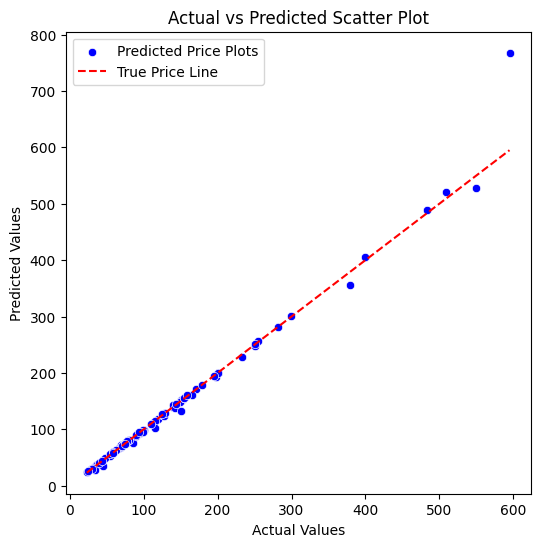

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))


sns.scatterplot(x=y_true, y=y_pred, label="Predicted Price Plots", color="blue", marker='o')


plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label="True Price Line")


plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Scatter Plot")


plt.legend()

plt.show()


In the scatter plot, the blue dots represent the actual prices and the red line represents the true prices. The model has performed well in predicting the prices, as the points are close to the red line. According to the plot, there is one price that is significantly off from the true price, which is around 890. However, the model is able to accurately predict the prices of other listings in Chicago. This model can be used to predict the prices of Airbnb listings in Chicago based on the provided features. So, if we give the necessary features of the listing, we can expect the model to provide an accurate estimate of its price.

In conclusion, we have successfully created a data pipeline, developed a machine learning model, and executed it with live data. The model was able to accurately predict the prices of Airbnb listings in Chicago. We have successfully aligned our model goal with the project's objective.

# Part 10: Reflection

Well I really wanted to learn about a data science project when I was studying Computer Science. I had heard lots of different projects on data science field but I never did any of the project. But after I started my MSDS program I really wanted to complete one data science project and in this course of Data Engineering I learned so many things like data cleaning, data visaulization, feature engineering, model selection, model evaluation, and finally how to use these models. I learned a lot from this course and I think it really helped me to understand how to work with data and solve real-world problems. I really wanted to apply my learnings to complete one of the project similar to real world problem like handling with raw data and simulating data pipeline. In this project I got a chance to apply my knowledge and skills in data engineering, machine learning, and even data visualization. I learned a lot about data pipeline, feature engineering, model selection, model evaluation, and how to use these models.

As I was so interested in doing this project I knew it was going to be fun but also very challenging beacuse I haven't done any this kind of project before on my own. I was really excited and I'm glad I did this project somehow. In this project I really loved the data cleaning part where I converted the categorical feature to numerical feature using encoding technique. I also loved simulating the data pipeline to make the raw data more understandle to model. After all this I applied my model to the raw data and gave the approximately accurate result which really satisfied me. I was really happy seeing the result and also was amazed seeing the predictions so much accurate to the real data. Its not that it was easy for me. I had problems in several section like optimizing model and executing raw data but the effort to solve them was worth it after I completed the project.

Well, I know some theoratical knowledge on deploying ML model to production but I haven't implemented it yet. But I'm sure it will be a great experience to learn how to deploy ML model to production. I think doing project on MLops will also be very fun and interesting and challenging as well. I'm looking forward to learning more about it. 